In [1]:
# default_exp optimizer

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
#export
import re
import IPython, graphviz

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import export_graphviz

from mip import Model, xsum, minimize, BINARY

from oae.core import *
from oae.tree import *

SEED = 41
np.random.seed(SEED)

# Optimizer

> Module that helps solve ILP ( Integer Linear Programming ) problem.

In [5]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [6]:
Xtr, Xte, ytr, yte = get_example_dataset()

In [7]:
clf = RandomForestClassifier(n_estimators=5, max_depth=3, random_state=SEED, n_jobs=-1)
clf.fit(Xtr, ytr)

RandomForestClassifier(max_depth=3, n_estimators=5, n_jobs=-1, random_state=41)

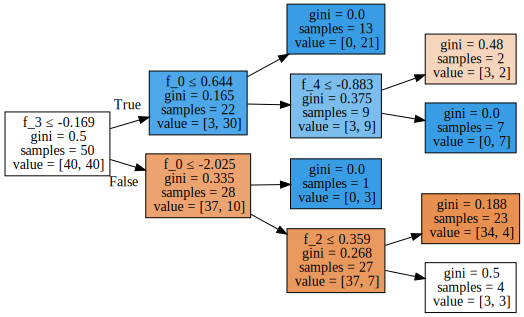

In [8]:
df_trn = pd.DataFrame(Xtr, columns=[f'f_{i}' for i in range(5)])
draw_tree(clf.estimators_[0], df_trn, precision=3)

In [9]:
#export
class Optimizer:
    def __init__(self, c_i_j, combine, z, class_):
        self.c_i_j = c_i_j
        self.combine = combine
        self.z = z
        self.class_ = class_
        
    def solve(self, atm:ATMSKLEARN, x:Instance):
        partitions  = atm.v_i_j(x)
        cost_matrix = self.c_i_j(partitions, x.content)
        
        model = Model()
        
        trees = atm.get_trees()
        
        # make v_i_j and phi_t_k as boolean variable in the integer linear programming problem
        v_i_j   = [[model.add_var(var_type=BINARY) for j in range(len(partitions[i]))] for i in range(len(x.content))]
        phi_t_k = [[model.add_var(var_type=BINARY) for j in range(len(atm.get_leaves(t.tree_)))] for t in trees] 
        
        
        # objective
        model.objective = minimize(xsum(v_i_j[i][j] * cost_matrix[i][j] for i in range(len(v_i_j)) \
                                        for j in range(len(v_i_j[i]))))

        # constraints
        w_t     = atm.calculate_tree_weights()
        h_t_k   = atm.h_t_k(combine, class_=self.class_)
        
        
        model += (xsum(phi_t_k[i][j] * h_t_k[i][j] * w_t[i] for i in range(len(trees)) \
                       for j in range(len(h_t_k[i]))) >= self.z)

        #check if feature value belongs to one and only one partition
        for i in range(len(x.content)):
            model += xsum(v_i_j[i][j] for j in range(len(v_i_j[i]))) == 1
        
        
        for i in range(len(x.content)):
            tree   = trees[i].tree_
            leaves = atm.get_leaves(tree)

            pi = {kidx:atm.find_ancestors(tree, 0, k, p=[])[1] for kidx, k in enumerate(leaves)}

            for j in range(len(leaves)):
                ancestors   = pi[j]
                n_ancestors = len(ancestors) # |pi_t_k|

                model += xsum(atm.predicates_mask(tree, a, partitions)[m] * v_i_j[tree.feature[a[0]]][m] \
                              for a in ancestors for m in range(len(v_i_j[tree.feature[a[0]]])))\
                              >= (phi_t_k[i][j] * n_ancestors)

        # check if instance is present in one and only one leaf node in
        # all trees
        for i in range(len(trees)):
            tree   = trees[i].tree_
            leaves = atm.get_leaves(tree)

            model += xsum(phi_t_k[i][j] for j in range(len(leaves))) == 1    

        # optimizing
        model.optimize()
        
        v_i_j_sol   = [[int(v_i_j[i][j].x) for j in range(len(v_i_j[i]))] for i in range(len(v_i_j))]
        phi_t_k_sol = [[int(phi_t_k[i][j].x) for j in range(len(phi_t_k[i]))] for i in range(len(phi_t_k))]
        
        return v_i_j_sol, phi_t_k_sol

In [10]:
#export
def cost_matrix(partitions, x, p=0):
    C_i_j    = []
    
    for i in range(len(x)):
        s = partitions[i]
        feat_cost = []
        for j in range(len(s)):
            if (x[i] >= s[j][0]) and (x[i] < s[j][1]):
                feat_cost.append(0)
            else:
                feat_cost.append(min((x[i] - s[j][0]) ** p, (x[i] - s[j][1]) ** p))
        C_i_j.append(feat_cost)
    
    return C_i_j

In [11]:
atm      = ATMSKLEARN(clf)
instance = Instance(Xte[10], ['numerical'] * 5)

opt = Optimizer(cost_matrix, combine, z=0.55, class_=1)
v_i_j_sol, phi_t_k_sol = opt.solve(atm, instance)

In [12]:
partitions = atm.v_i_j(instance)
orig_mask = atm.v_i_j_mask(partitions, instance); orig_mask

[[0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0]]

In [13]:
atm.suggest_changes(v_i_j_sol, instance)

['current value: -0.8669707011895302, proposed range: [0.8496142029762268, 100000000.0]',
 'no change, current value: 1.0284841573827033',
 'current value: -0.35223477173473217, proposed range: [0.6645539551973343, 100000000.0]',
 'no change, current value: -0.04852384360194605',
 'no change, current value: -0.7400914519032277']

In [14]:
atm.transform(v_i_j_sol, instance)

,f_0,f_1,f_2,f_3,f_4
0,6.623099e+06,1.028484,5.662912e+06,-0.048524,-0.740091


## Export

In [15]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_Representation.ipynb.
Converted 02_Optimizer.ipynb.
Converted index.ipynb.
